In [87]:
import pandas as pd
import numpy as np
import os
import sqlite3
import math
from constant_values import get_passing_stat_ids, get_rushing_stat_ids, get_receiving_stat_ids, get_general_stat_ids, id_2_col, operation_2_str, year_2_idx
from scipy import stats
from matplotlib import pyplot as plt
import csv
import time
from itertools import chain
import json

In [88]:
# ==== Config =====
CURRENT_DIR = os.path.dirname('.')
PROJECT_ROOT_DIR = os.path.join(CURRENT_DIR, '..', '..')
config = json.load(open(os.path.join(PROJECT_ROOT_DIR, 'config.json'), 'r'))

In [126]:
# ==== Output Files =====
DATA_DIR = os.path.join(PROJECT_ROOT_DIR, 'data')
DATABASE_DIR = config['sql']['db_dir']
DATABASE_FILENAME = config['sql']['db_name']
DATABASE_PATH = os.path.join(DATABASE_DIR, DATABASE_FILENAME)
conn = sqlite3.connect(DATABASE_PATH)
print('OPENED CONNECTION')

OPENED CONNECTION


In [108]:
# ==== Constants =====
STAT_KEYS = ['home_mean', 'road_mean', 'home_std', 'road_std', 'home_count', 'road_count', 't_stat', 'p_val', 'cohen', 'my_t', 'difference', 'pct_difference', 'stat_type']
passing_lower_ids = get_passing_stat_ids()
rushing_lower_ids = get_rushing_stat_ids()
receiving_lower_ids = get_receiving_stat_ids()
general_lower_ids = get_general_stat_ids()
lower_id_2_sql = id_2_col()

In [109]:
# ==== SQL Statemnt Formatter =====
def get_kvd_value(val):
    """
    params:
        - val (int OR float OR str): Value in Key-Value dictionary for SQL Statement
    returns:
        - val (str): String version of value
    """
    if isinstance(val, str):
        return "'" + str(val) + "'"
    return str(val)

def format_sql_where(key_value_dict):
    """
    params:
        - key_value_dict (dict): SQL WHERE statement in input format
    returns:
        - statement (str): SQL formatted WHERE statement
    """
    statement_list = ['{0} {1} {2}'.format(k, key_value_dict[k]['operation'], get_kvd_value(key_value_dict[k]['value'])) for k in key_value_dict]
    statement = ' AND '.join(statement_list)
    return statement

def get_sql_statement(key_value_dict, data_type):
    """
    params:
        - key_value_dict (dict): SQL statement in input format
        - data_type (str): The table we are querying (passing, rushing, receiving)
    returns:
        - statement (str): SQL formatted statement
    """
	table = 'passing_statistics'
	if data_type == 'rushing':
		table = 'rushing_statistics'
	elif data_type == 'receiving':
		table = 'receiving_statistics'

	statement = '''SELECT * FROM %s''' % table
	if len(key_value_dict) > 0:
		statement += ' WHERE ' + format_sql_where(key_value_dict)

	return statement + ';'

TabError: inconsistent use of tabs and spaces in indentation (<ipython-input-109-8f93a774a38f>, line 32)

In [110]:
# ==== Load Games From SQL
def get_road_games(key_value_dict, data_type):
    """
    params:
        - key_value_dict (dict): SQL statement in input format
        - data_type (str): The table we are querying (passing, rushing, receiving)
    returns:
        - road_games (pandas DataFrame): Results of SQL query for road games
    """
    key_value_dict['GAME_LOCATION'] = {
        'value': '@',
        'operation': '='
    }

    statement = get_sql_statement(key_value_dict, data_type)
    road_games = pd.read_sql_query(statement, conn)
    return road_games

def get_home_games(key_value_dict, data_type):
    """
    params:
        - key_value_dict (dict): SQL statement in input format
        - data_type (str): The table we are querying (passing, rushing, receiving)
    returns:
        - home_games (pandas DataFrame): Results of SQL query for road games
    """
    key_value_dict['GAME_LOCATION'] = {
        'value': '',
        'operation': '='
    }
    statement = get_sql_statement(key_value_dict, data_type)
    home_games = pd.read_sql_query(statement, conn)
    return home_games

In [111]:
l = {
        'YEAR': {
            'value': 2008,
            'operation': '='
        },
        'PASS_ATTEMPTS': {
            'value': 10,
            'operation': '>='
        }
}
hg = get_home_games(l, 'passing')
print(hg.shape)
print(hg.columns)
print(np.mean(hg['PASS_ADJ_YARDS_PER_ATTEMPT']))
hg.head()

(275, 25)
Index(['GAME_ID', 'PLAYER_ID', 'NAME', 'AGE', 'PLAYOFFS', 'YEAR', 'DATE',
       'GAME_NUM', 'TEAM', 'POSITION', 'GAME_LOCATION', 'OPPONENT', 'RESULT',
       'STARTED', 'PASS_COMPLETIONS', 'PASS_ATTEMPTS', 'PASS_COMP_PCT',
       'PASS_YARDS', 'PASS_TD', 'PASS_INT', 'PASS_RATING', 'PASS_SACKED',
       'PASS_SACKED_YARDS', 'PASS_YARDS_PER_ATT',
       'PASS_ADJ_YARDS_PER_ATTEMPT'],
      dtype='object')
6.760254545454551


,GAME_ID,PLAYER_ID,NAME,AGE,PLAYOFFS,YEAR,DATE,GAME_NUM,TEAM,POSITION,...,PASS_ATTEMPTS,PASS_COMP_PCT,PASS_YARDS,PASS_TD,PASS_INT,PASS_RATING,PASS_SACKED,PASS_SACKED_YARDS,PASS_YARDS_PER_ATT,PASS_ADJ_YARDS_PER_ATTEMPT
0,91,0,Drew Brees,29.236,0,2008,2008-09-07,1,NOR,QB,...,32,71.88,343,3,1,124.9,1,6,10.72,11.19
1,94,0,Drew Brees,29.257,0,2008,2008-09-28,4,NOR,QB,...,35,65.71,363,3,1,116.7,0,0,10.37,10.80
2,95,0,Drew Brees,29.265,0,2008,2008-10-06,5,NOR,QB,...,46,56.52,330,1,2,68.2,1,10,7.17,5.65
3,96,0,Drew Brees,29.271,0,2008,2008-10-12,6,NOR,QB,...,30,86.67,320,3,0,144.4,1,1,10.67,12.67
4,98,0,Drew Brees,29.285,0,2008,2008-10-26,8,NOR,QB,...,41,73.17,339,3,0,121.9,0,0,8.27,9.73


In [112]:
# ==== Statistic Helper Functions =====
def stat_id_list_2_col_list(stat_id_list):
    """
    params:
        - stat_id_list (list of str): List of stat IDs in format from website
    returns:
        - stat_id_list_formatted (list of str): List of stat IDs in format from SQL
    """
    return [lower_id_2_sql[x] for x in stat_id_list]

def mapPctToDec(games_stat):
    """
    params:
        - games_stat (pandas Series): List of stat values
    returns:
        - mapped_games (pandas Series): Percent-formatted list of stat values
    """
    mapped_games = []
    for g in games_stat:
        mapped_games.append(float(g.replace('%', ''))/100.0)
    return pd.Series(mapped_games)

def get_t_stats(home_games_stat, road_games_stat, stat_id):
    """
    params:
        - home_games_stat (pandas Series): List of home values
        - road_games_stat (pandas Series): List of road values
        - stat_id (str): Type of stat you're looking at (unnecessary)???
    returns:
        - t_stat (float): T-statistic from numpy
        - p_val (float): P-value of differences between home/road games
        - cohen (float): Cohen's d between home and road games
        - my_t (float): Manual calculation of t-statistic from other values
    """
    home_mean = np.mean(home_games_stat)
    road_mean = np.mean(road_games_stat)
    home_std = np.std(home_games_stat)
    road_std = np.std(road_games_stat)
    pooled_std = math.sqrt(((len(home_games_stat)-1)*home_std**2 + (len(road_games_stat)-1)*road_std**2)/(len(home_games_stat) + len(road_games_stat) - 2))
    standard_error = math.sqrt(home_std**2/(len(home_games_stat)-1) + road_std**2/(len(road_games_stat)-1))
    t_stat, p_val = stats.ttest_ind(home_games_stat, road_games_stat)
    cohen = (home_mean - road_mean)/pooled_std
    my_t = (home_mean - road_mean)/standard_error
    return t_stat, p_val, cohen, my_t

In [113]:
# ==== Wrapper Function To Get Stats Given Games =====
def get_stats(home_games_stat, road_games_stat, stat_id):
    """
    params:
        - home_games_stat (pandas Series): List of home values
        - road_games_stat (pandas Series): List of road values
        - stat_id (str): Type of stat you're looking at
    returns:
        - stat_dict (dict): A dictionary of stat values
    """
    if stat_id in passing_lower_ids or stat_id in stat_id_list_2_col_list(passing_lower_ids):
        stat_type = 'passing'
    elif stat_id in rushing_lower_ids or stat_id in stat_id_list_2_col_list(rushing_lower_ids):
        stat_type = 'rushing'
    elif stat_id in receiving_lower_ids or stat_id in stat_id_list_2_col_list(receiving_lower_ids):
        stat_type = 'receiving'
    else:
        raise Exception('Invalid Stat: ' + stat_id)
        
    if type(home_games_stat[0]) == str:
        if '%' not in home_games_stat[0]:
            raise Exception('Stat is not numeric')
        else:
            home_games_stat = mapPctToDec(home_games_stat)
            road_games_stat = mapPctToDec(road_games_stat)

    t_stat, pval, cohen, my_t = get_t_stats(home_games_stat, road_games_stat, stat_id)

    home_mean = np.mean(home_games_stat)
    road_mean = np.mean(road_games_stat)

    return {
    'home_mean': home_mean,
    'road_mean': road_mean,
    'home_std': np.std(home_games_stat),
    'road_std': np.std(road_games_stat),
    'home_count': len(home_games_stat),
    'road_count': len(road_games_stat),
    't_stat': t_stat,
    'p_val': pval,
    'cohen': cohen,
    'my_t': my_t,
    'difference': home_mean - road_mean,
    'pct_difference': (max([home_mean, road_mean]) - min([home_mean, road_mean]))/min([home_mean, road_mean]),
    'stat_type': stat_type
    }

def get_stat_dict(home_games, road_games, lower_stat_id_list):
    """
    params:
        - home_games (pandas DataFrame): All home stat values specified
        - road_games (pandas DataFrame): All road stat values specified
        - stat_id (str): List of stat_ids (website format)
    returns:
        - stat_dict (dict): A dictionary of stat values for every statistic
    """
    stat_dict = {}
    for s_id in lower_stat_id_list:
        hg_stats = home_games[lower_id_2_sql[s_id]]
        rg_stats = road_games[lower_id_2_sql[s_id]]
        stat_dict[lower_id_2_sql[s_id]] = get_stats(hg_stats, rg_stats, s_id)
    return stat_dict

In [114]:
# ==== Organize Inputs =====
def get_key_value_dict(data_type):
    """
    params:
        - data_type (str): The type of data we're looking at (passing, rushing, receiving)
    returns:
        - l (dict): A dictionary giving all information required for SQL query
    """
    if data_type == 'receiving':
        l = {
                'YEAR': {
                    'value': 2008,
                    'operation': '>='
                }
            }
    elif data_type == 'passing':
        l = {
                'YEAR': {
                    'value': 2008,
                    'operation': '>='
                },
                'PASS_ATTEMPTS': {
                    'value': 10,
                    'operation': '>='
                }
            }
    elif data_type == 'rushing':
        l = {
                'YEAR': {
                    'value': 2008,
                    'operation': '>='
                },
                'RUSH_ATTEMPTS': {
                    'value': 5,
                    'operation': '>='
                }
            }
    else:
        raise Excpetion('Bad DATA_TYPE')
    return l

In [115]:
# ==== Format Output =====
def get_filename(key_value_dict, data_type):
    """
    parmas:
        - key_value_dict (dict): A dict with all SQL query info
        - data_type (str): The type of statistics being examined
    returns:
        - filename (str): The filename of the output stat CSV
    """
    type_file_dir = os.path.join(DATA_DIR, 'interim', data_type)
    filename = data_type + '_'
    for key in key_value_dict:
        filename += key + '_'
        filename += operation_2_str()[key_value_dict[key]['operation']] + '_' + str(key_value_dict[key]['value']) + '_'
    return os.path.join(type_file_dir, filename[:-1] + '.csv')

In [116]:
def get_stat_ids(data_type):
    """
    params:
        - data_type (str): The type of statistics being examined
    returns:
        - lower_ids (list of str): A list of stat IDs in website format
    """
	if data_type == 'passing':
		return passing_lower_ids
	elif data_type == 'rushing':
		return rushing_lower_ids
	elif data_type == 'receiving':
		return receiving_lower_ids
	raise Exception('Data Type Incorrect')
	return None

TabError: inconsistent use of tabs and spaces in indentation (<ipython-input-116-919803037eb1>, line 8)

In [128]:
# ==== Write Results =====
def write_query_info_to_csv(csv_writer, key_value_dict):
    """
    params:
        - csv_writer (csv writer object): CSV writer
        - key_value_dict (dict): Dict of SQL query info
    returns:
        NONE (writes to file)
    """
    for k in key_value_dict:
        csv_writer.writerow([k, key_value_dict[k]['operation'], key_value_dict[k]['value']])
    header_row = ['stat_id']
    header_row.extend(STAT_KEYS)
    csv_writer.writerow([])
    csv_writer.writerow(header_row)
    
def write_stat_to_csv(stat_vals, stat_id, csv_writer):
    """
    params:
        - stat_vals (list): All stat values for an individual row
        - stat_id (str): The statistic being looked at
        - csv_writer (csv writer object): CSV writer
    returns:
        NONE (writes to file)
    """
    stat_row = [stat_vals[key] for key in STAT_KEYS]
    stat_row.insert(0, stat_id)
    csv_writer.writerow(stat_row)
    
def write_all_aggregated_stats(automatically_overwrite=True):
    """
    params:
        automatically_overwrite (bool): To overwrite existing file or not
    returns:
        NONE (writes to file)
    """
    for dt in ['passing', 'rushing', 'receiving']:
        kvd = get_key_value_dict(dt)
        output_file = get_filename(kvd, dt)
        if os.path.isfile(output_file) and not automatically_overwrite:
            raise Exception('File already exists')
        road_qb_games = get_road_games(kvd.copy(), dt)
        home_games = get_home_games(kvd.copy(), dt)
        print(output_file)
        csv_file = open(output_file, 'w')
        csv_writer = csv.writer(csv_file)
        print(csv_writer)
        write_query_info_to_csv(csv_writer, kvd.copy())
        stat_id_list = get_stat_ids(dt)
        stat_dict = get_stat_dict(home_games, road_qb_games, stat_id_list)
        for stat_id in stat_dict:
            write_stat_to_csv(stat_dict[stat_id], stat_id, csv_writer)

        csv_writer.writerow([])
        csv_writer.writerow([])
        csv_file.close()

In [129]:
# ==== Plotting Statistic Helpers
def get_bins(home_games, road_games, col, num_bins=20):
    """
    params:
        - home_games (pandas Series): List of home game values
        - road_games (pandas Series): List of road game values
        - col (str): Column being examined (unnecessary)???
        - num_bins (int): Number of bins in histogram
    returns:
        - bins (numpy array): Bin values for histogram
    """
    min_val = min(min(home_games.unique()), min(road_games.unique()))
    max_val = max(max(home_games.unique()), max(road_games.unique()))
    if len(home_games.unique()) < num_bins or len(road_games.unique()) < num_bins:
        return range(int(min_val), int(max_val))
    bins = np.linspace(0, max_val, num=num_bins)
    return bins

def get_hist_text(final_stats):
    """
    params:
        - final_stats (dict): Processed stat values
    returns:
        - s (str): Text to display on histogram plot
    """
    s = 'Home Mean: ' + '{0:.3f}'.format(final_stats['home_mean']) + ' (n=' + str(final_stats['home_count']) + ')\n'
    s += 'Road Mean: ' + '{0:.3f}'.format(final_stats['road_mean']) + ' (n=' + str(final_stats['road_count']) + ')\n'
    s += 'Diff: ' + '{0:.3f}'.format(final_stats['difference']) + '\n'
    s += 'P Val: ' + '{0:.5f}'.format(final_stats['p_val']) + '\n'
    return s

def mod_games(game_stats):
    """
    params:
        - game_stats (pandas Series): Stat values for individual statistics
    returns:
        - game_stats (pandas Series): Modified stat values for individual statistics
    """
    print('game_stats', type(game_stats), game_stats)
    if type(game_stats[0]) == str:
        if '%' not in game_stats[0]:
            raise Exception('Stat is not numeric')
        else:
            return mapPctToDec(game_stats)
    return game_stats

In [130]:
# ==== Plot All Stats =====
def plot_stats(home_games, road_games, data_type):
    """
    params:
        - home_games (pandas DataFrame): All home game stat values
        - road_games (pandas DataFrame): All road game stat values
        - data_type (str): Type of data being looked at (passing, rushing, receiving)
    returns:
        NONE (creates pyplot plots)
    """
    stat_id_list = get_stat_ids(data_type)
    stat_dict = get_stat_dict(home_games, road_games, stat_id_list)
    fig, axs = plt.subplots(nrows=math.ceil(len(stat_id_list)/2), ncols=2)
    fig.set_size_inches(30, 60)
    home_hist_vals = {}
    road_hist_vals = {}
    for col, ax in zip(stat_dict.keys(), chain(*axs)):
        home_games_mod = mod_games(home_games[col])
        road_games_mod = mod_games(road_games[col])
        bins = get_bins(home_games_mod, road_games_mod, col)
        home_n, home_bins, home_patches = ax.hist(home_games_mod, label='Home', alpha=0.5, bins=bins)
        road_n, road_bins, road_patches = ax.hist(road_games_mod, label='Road', alpha=0.5, bins=bins)
        home_hist_vals[col] = { 'n': home_n, 'bins': home_bins, 'patches': home_patches }
        road_hist_vals[col] = { 'n': road_n, 'bins': road_bins, 'patches': road_patches }
        ax.legend(loc='upper right')
        ax.text(0.05, 0.95, get_hist_text(stat_dict[col]), transform=ax.transAxes, fontsize=14,
            verticalalignment='top')
        ax.set_title(col)

In [131]:
OVERALL_STAT_DICT = {}

game_stats <class 'pandas.core.series.Series'> 0       23
1       23
2       26
3       26
4       30
5       20
6       18
7       30
8       26
9       20
10      23
11      25
12      24
13      18
14      29
15      32
16      27
17      30
18      33
19      37
20      34
21      29
22      25
23      22
24      26
25      31
26      31
27      27
28      24
29      26
        ..
2995    10
2996    24
2997    17
2998    24
2999    24
3000    15
3001    21
3002    23
3003     9
3004    26
3005    12
3006    18
3007    10
3008     8
3009    18
3010    13
3011    17
3012    16
3013    27
3014    20
3015    20
3016    22
3017    17
3018    25
3019    14
3020    13
3021    14
3022    14
3023    14
3024    14
Name: PASS_COMPLETIONS, Length: 3025, dtype: int64
game_stats <class 'pandas.core.series.Series'> 0       22
1       39
2       21
3       31
4       25
5       25
6       24
7       30
8       25
9       16
10      22
11      18
12      19
13      35
14      31
15      28
16      

game_stats <class 'pandas.core.series.Series'> 0       11.19
1       10.80
2        5.65
3       12.67
4        9.73
5       15.50
6        8.44
7        8.59
8       12.74
9        5.94
10      14.97
11       9.18
12       8.71
13      20.48
14       6.07
15       7.51
16       7.14
17       8.82
18       6.15
19       3.86
20       6.82
21       8.65
22       4.78
23       4.50
24       8.92
25       7.73
26      12.14
27       7.03
28      11.66
29      11.17
        ...  
2995     9.68
2996     9.17
2997     2.17
2998     7.71
2999    11.46
3000     7.41
3001     2.03
3002     6.18
3003     5.30
3004     4.76
3005     3.78
3006     5.30
3007     1.95
3008     9.47
3009     3.22
3010     8.62
3011     9.19
3012    14.64
3013     4.62
3014     9.91
3015    10.17
3016     5.16
3017     6.03
3018     5.70
3019     3.18
3020     5.53
3021     4.32
3022     6.57
3023     7.46
3024     6.52
Name: PASS_ADJ_YARDS_PER_ATTEMPT, Length: 3025, dtype: float64
game_stats <class 'pandas.core.serie

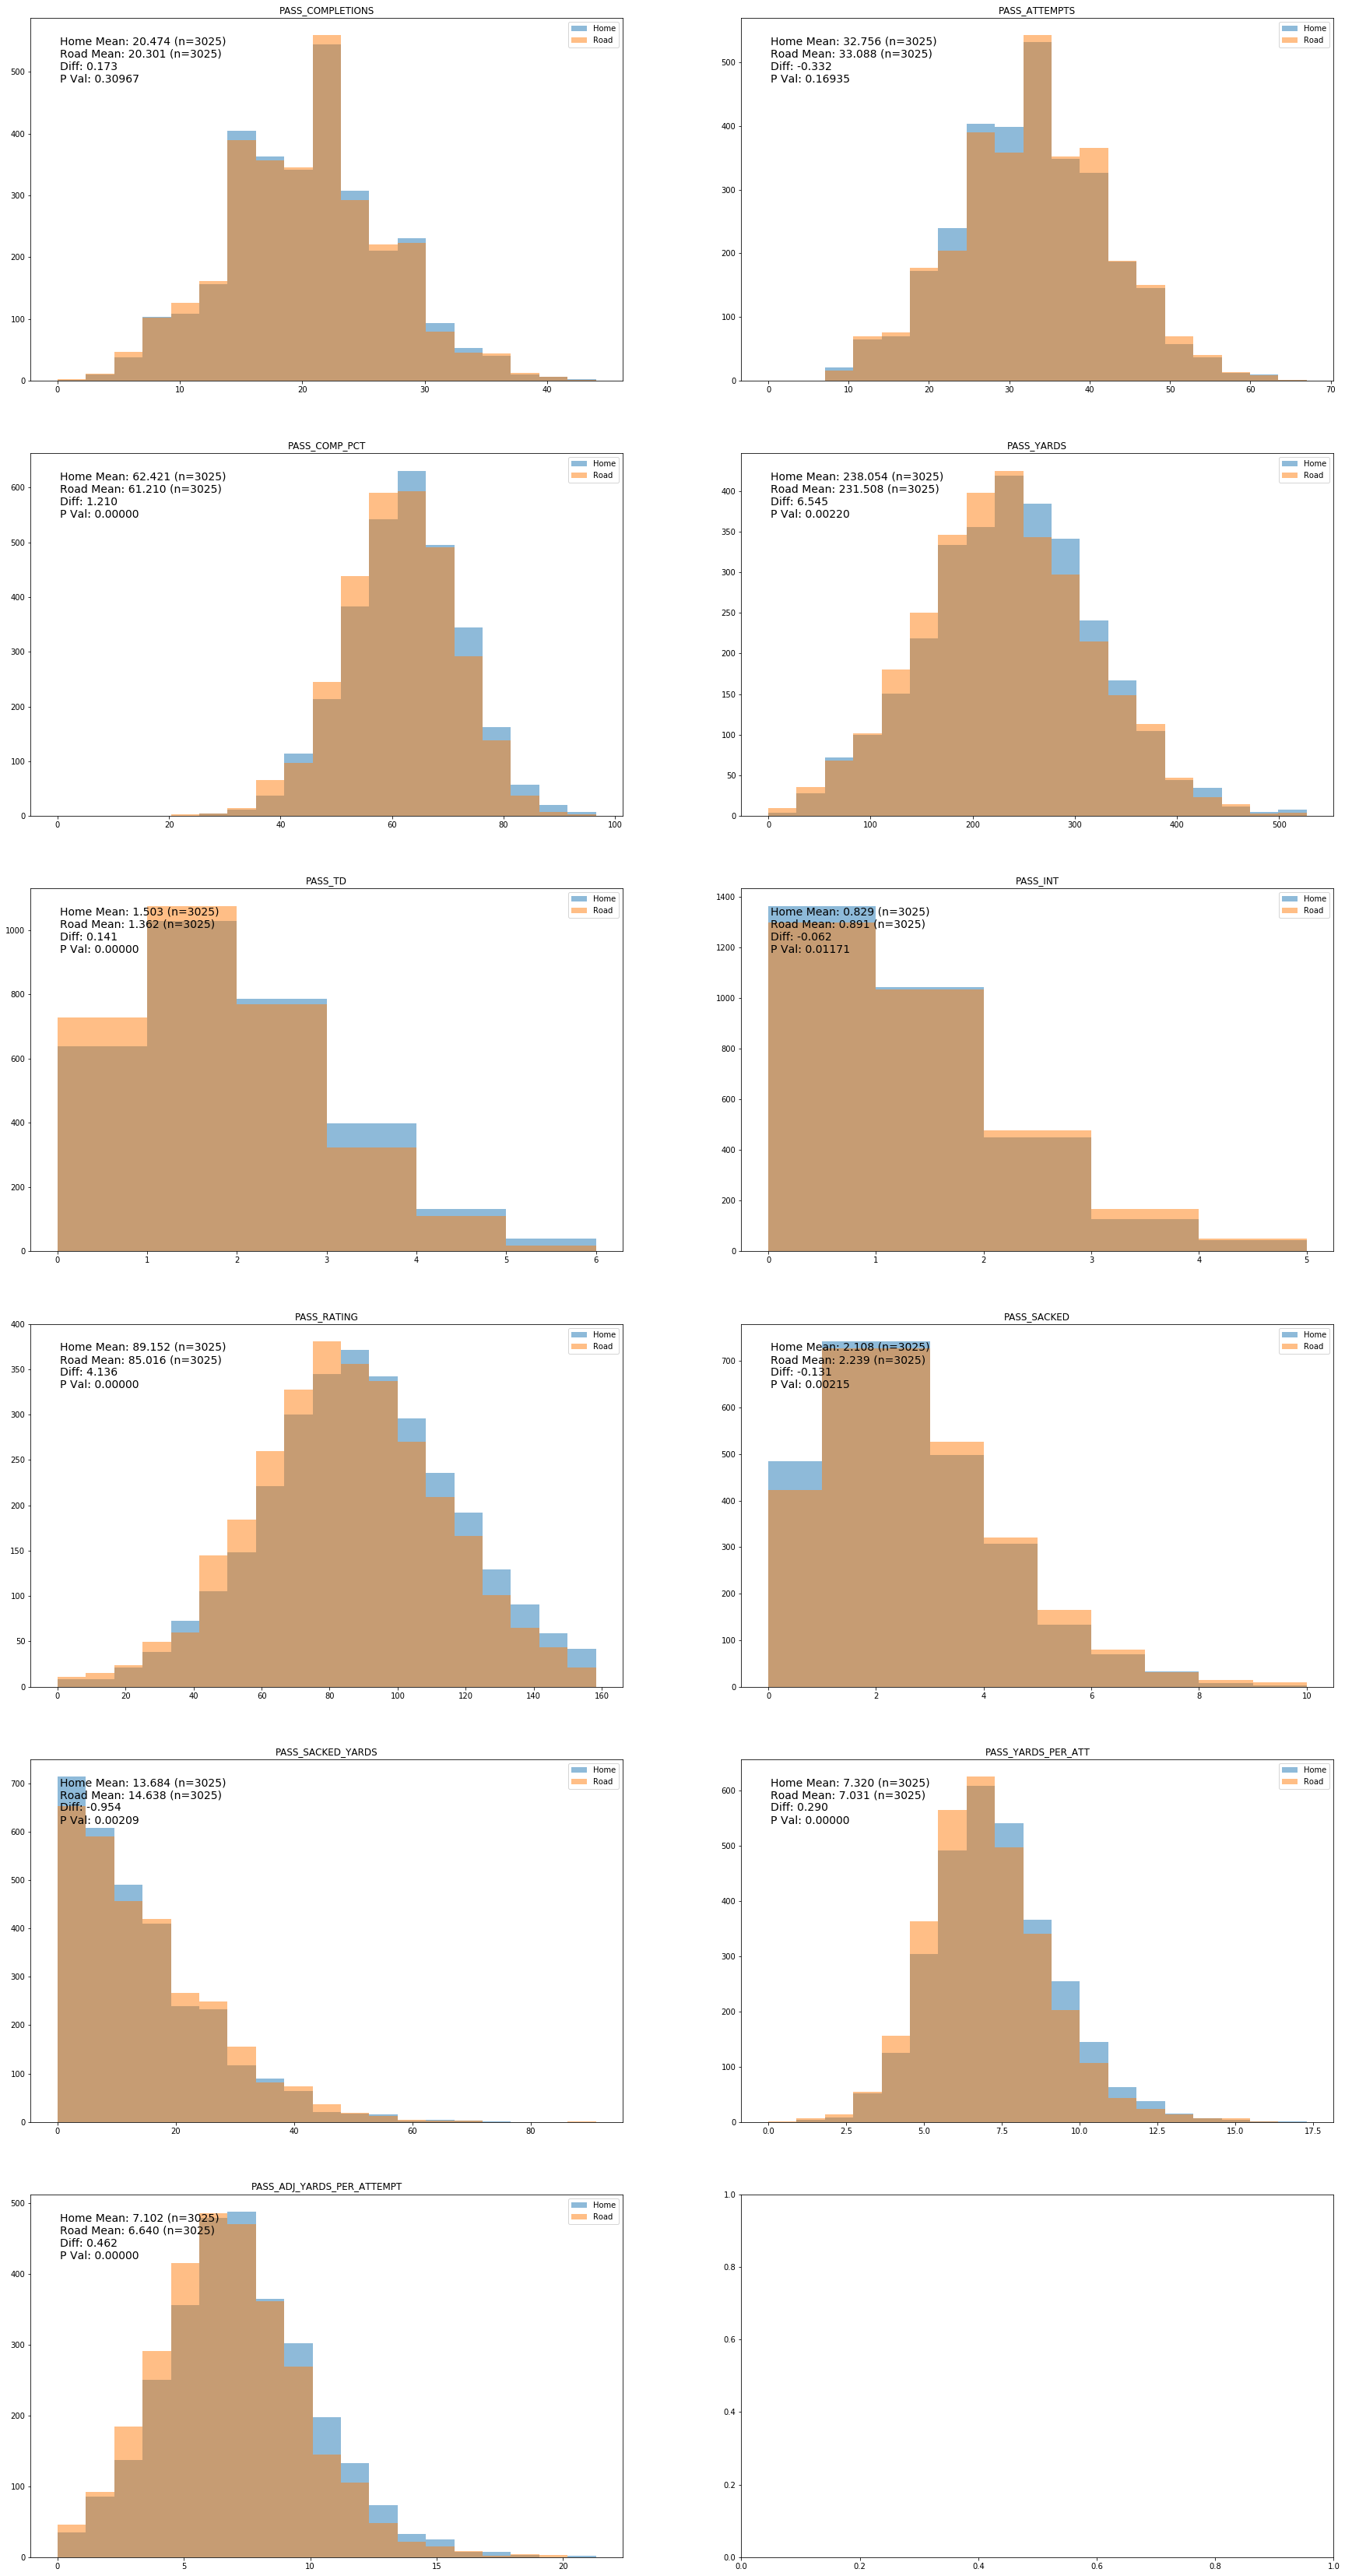

In [132]:
dt = 'passing'
kvd = get_key_value_dict(dt)
hg = get_home_games(kvd.copy(), dt)
rg = get_road_games(kvd.copy(), dt)
stat_dict = get_stat_dict(hg, rg, get_stat_ids(dt))
OVERALL_STAT_DICT.update(stat_dict)
plot_stats(hg, rg, dt)

game_stats <class 'pandas.core.series.Series'> 0        6
1        5
2        8
3        8
4        5
5        5
6        7
7        5
8        5
9        5
10       8
11       6
12       5
13       5
14       8
15       5
16       5
17       5
18       5
19       7
20       5
21       5
22       7
23       9
24       7
25       6
26       5
27       5
28       5
29       8
        ..
5440     6
5441     7
5442     9
5443     5
5444     5
5445     5
5446     9
5447     6
5448     8
5449     7
5450     8
5451    23
5452     7
5453    11
5454     5
5455     5
5456     5
5457    14
5458     8
5459     6
5460     5
5461    19
5462     7
5463     7
5464     7
5465    15
5466     6
5467    14
5468    11
5469     5
Name: RUSH_ATTEMPTS, Length: 5470, dtype: int64
game_stats <class 'pandas.core.series.Series'> 0        6
1        5
2        5
3        5
4        7
5        5
6        5
7        5
8        5
9        5
10       5
11       6
12       5
13       5
14       6
15       5
16       5


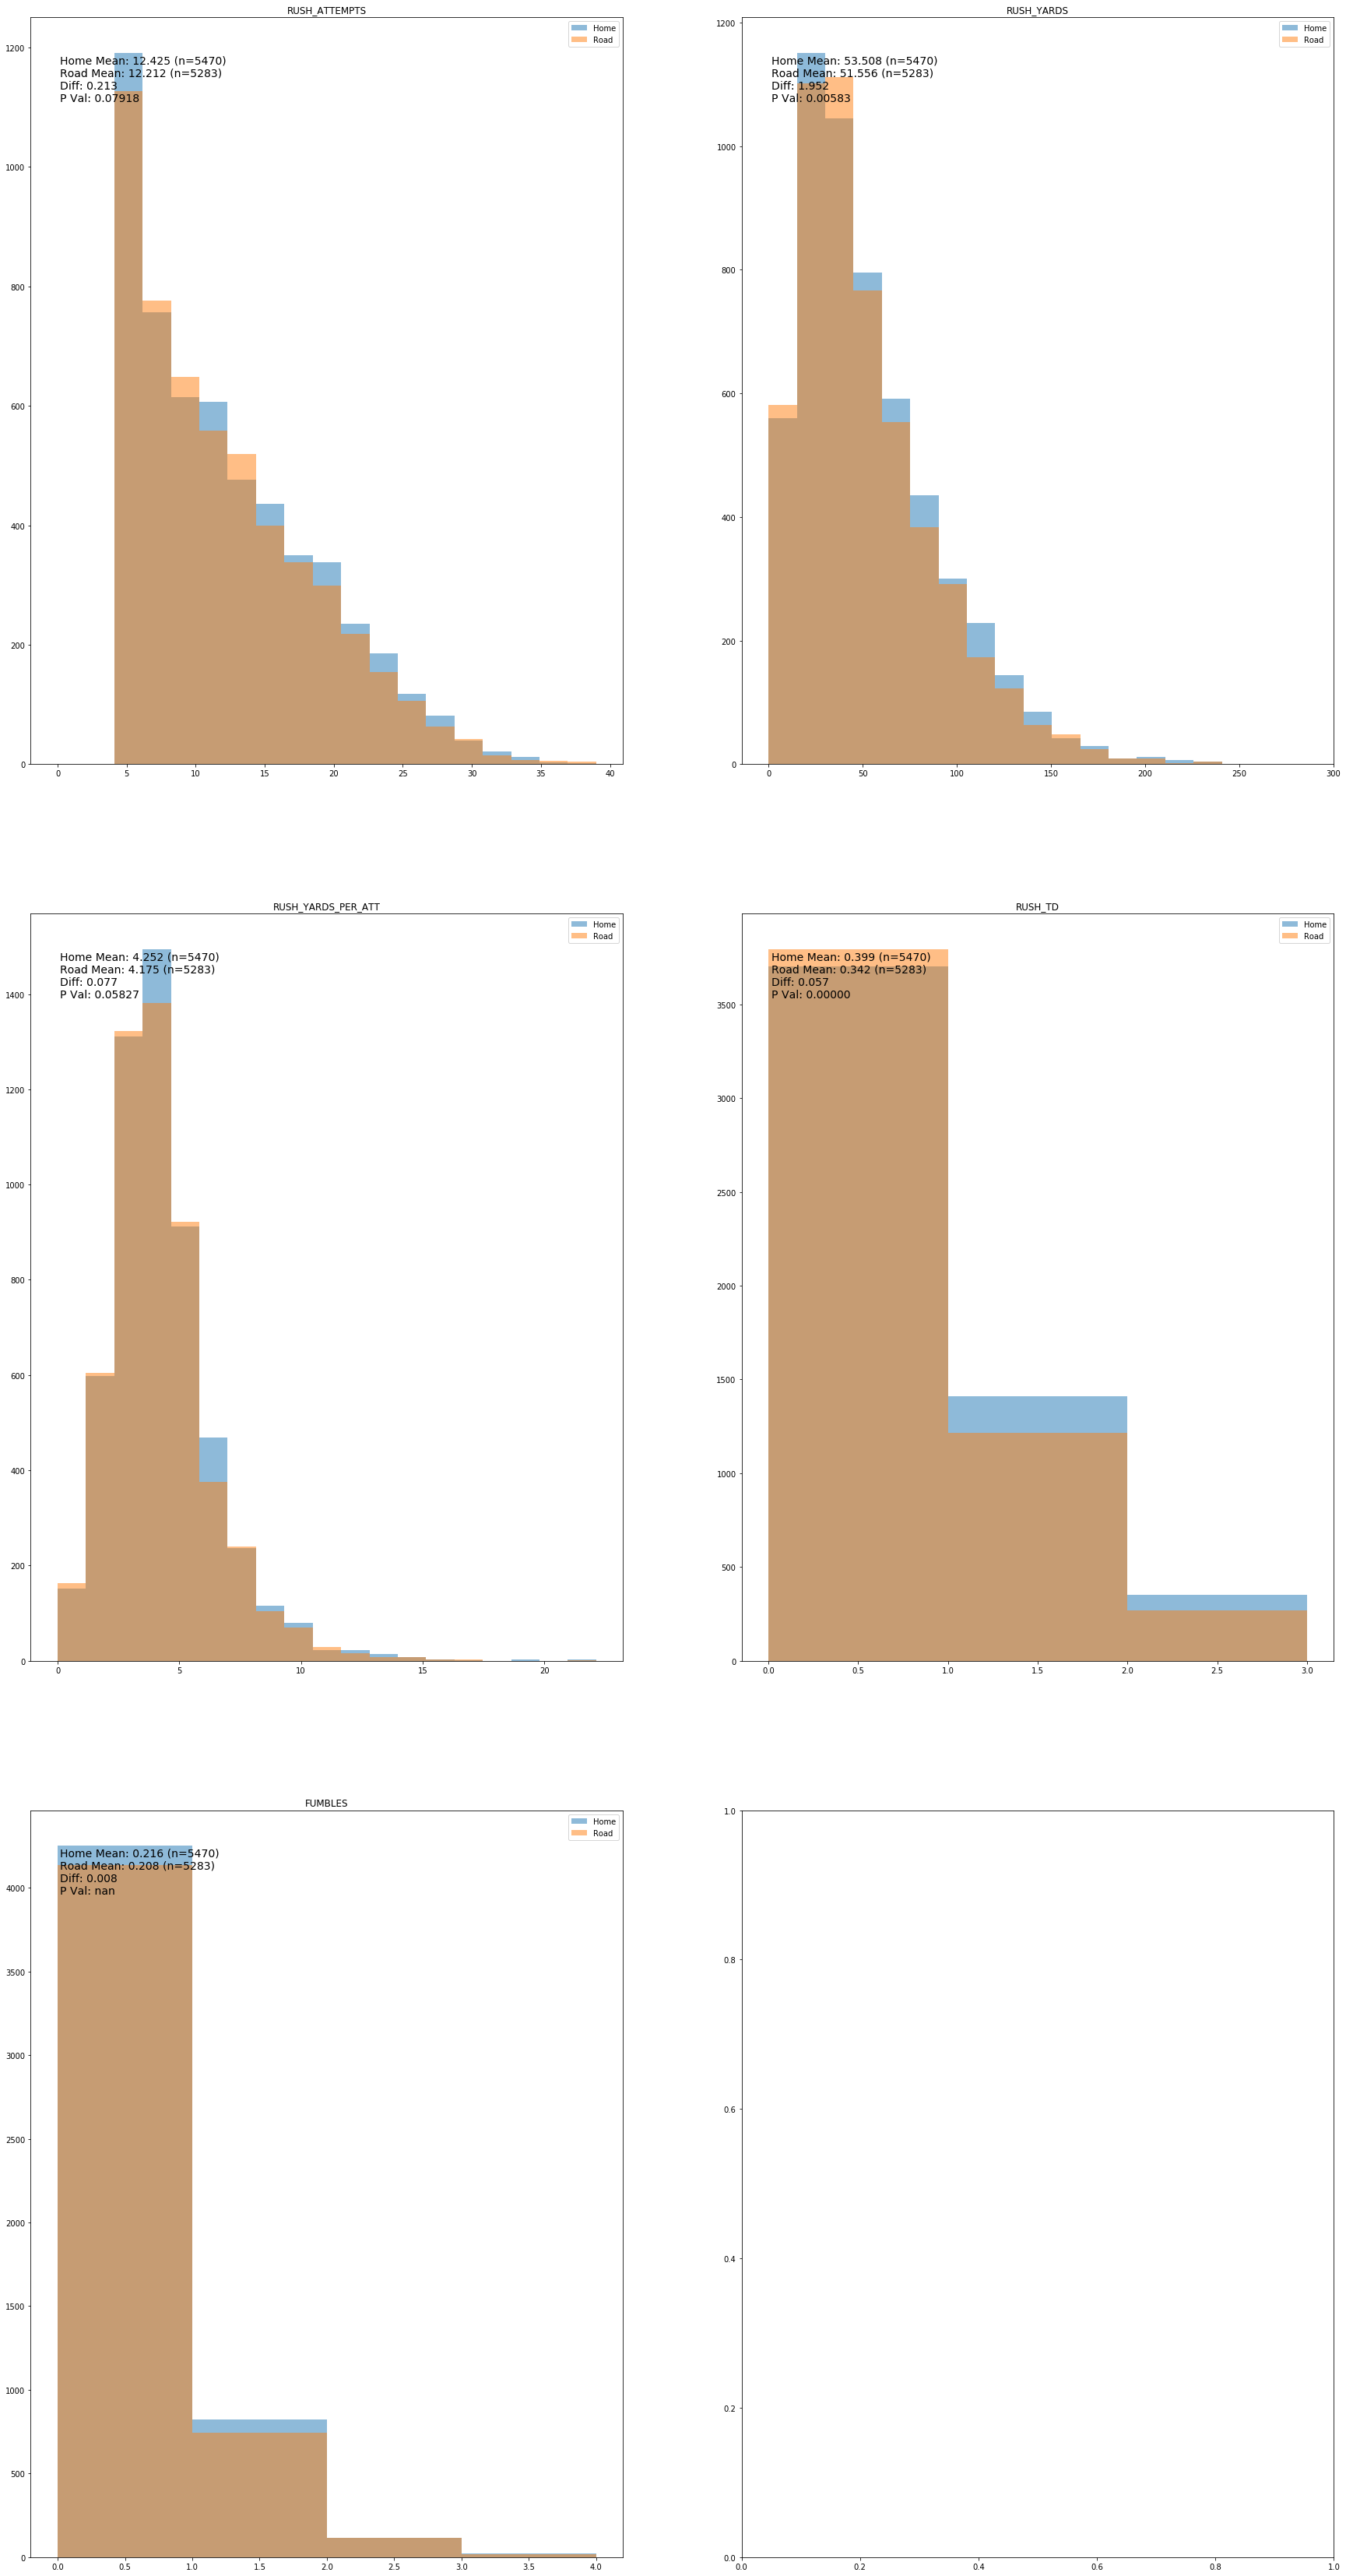

In [133]:
dt = 'rushing'
kvd = get_key_value_dict(dt)
hg = get_home_games(kvd.copy(), dt)
rg = get_road_games(kvd.copy(), dt)
stat_dict = get_stat_dict(hg, rg, get_stat_ids(dt))
OVERALL_STAT_DICT.update(stat_dict)
plot_stats(hg, rg, dt)

game_stats <class 'pandas.core.series.Series'> 0        1
1        1
2        1
3        1
4        1
5        1
6        1
7        1
8        1
9        1
10       1
11       1
12       1
13       1
14       1
15       1
16       1
17       3
18       2
19       2
20       7
21       1
22       1
23       1
24       5
25       4
26       5
27       3
28       1
29       2
        ..
23175    1
23176    1
23177    1
23178    1
23179    1
23180    2
23181    1
23182    1
23183    2
23184    4
23185    2
23186    1
23187    1
23188    1
23189    2
23190    1
23191    1
23192    1
23193    1
23194    1
23195    2
23196    1
23197    1
23198    1
23199    1
23200    1
23201    1
23202    1
23203    1
23204    1
Name: TARGETS, Length: 23205, dtype: int64
game_stats <class 'pandas.core.series.Series'> 0        1
1        1
2        1
3        1
4        1
5        1
6        1
7        1
8        1
9        1
10       1
11       1
12       1
13       1
14       1
15       1
16       1
17   

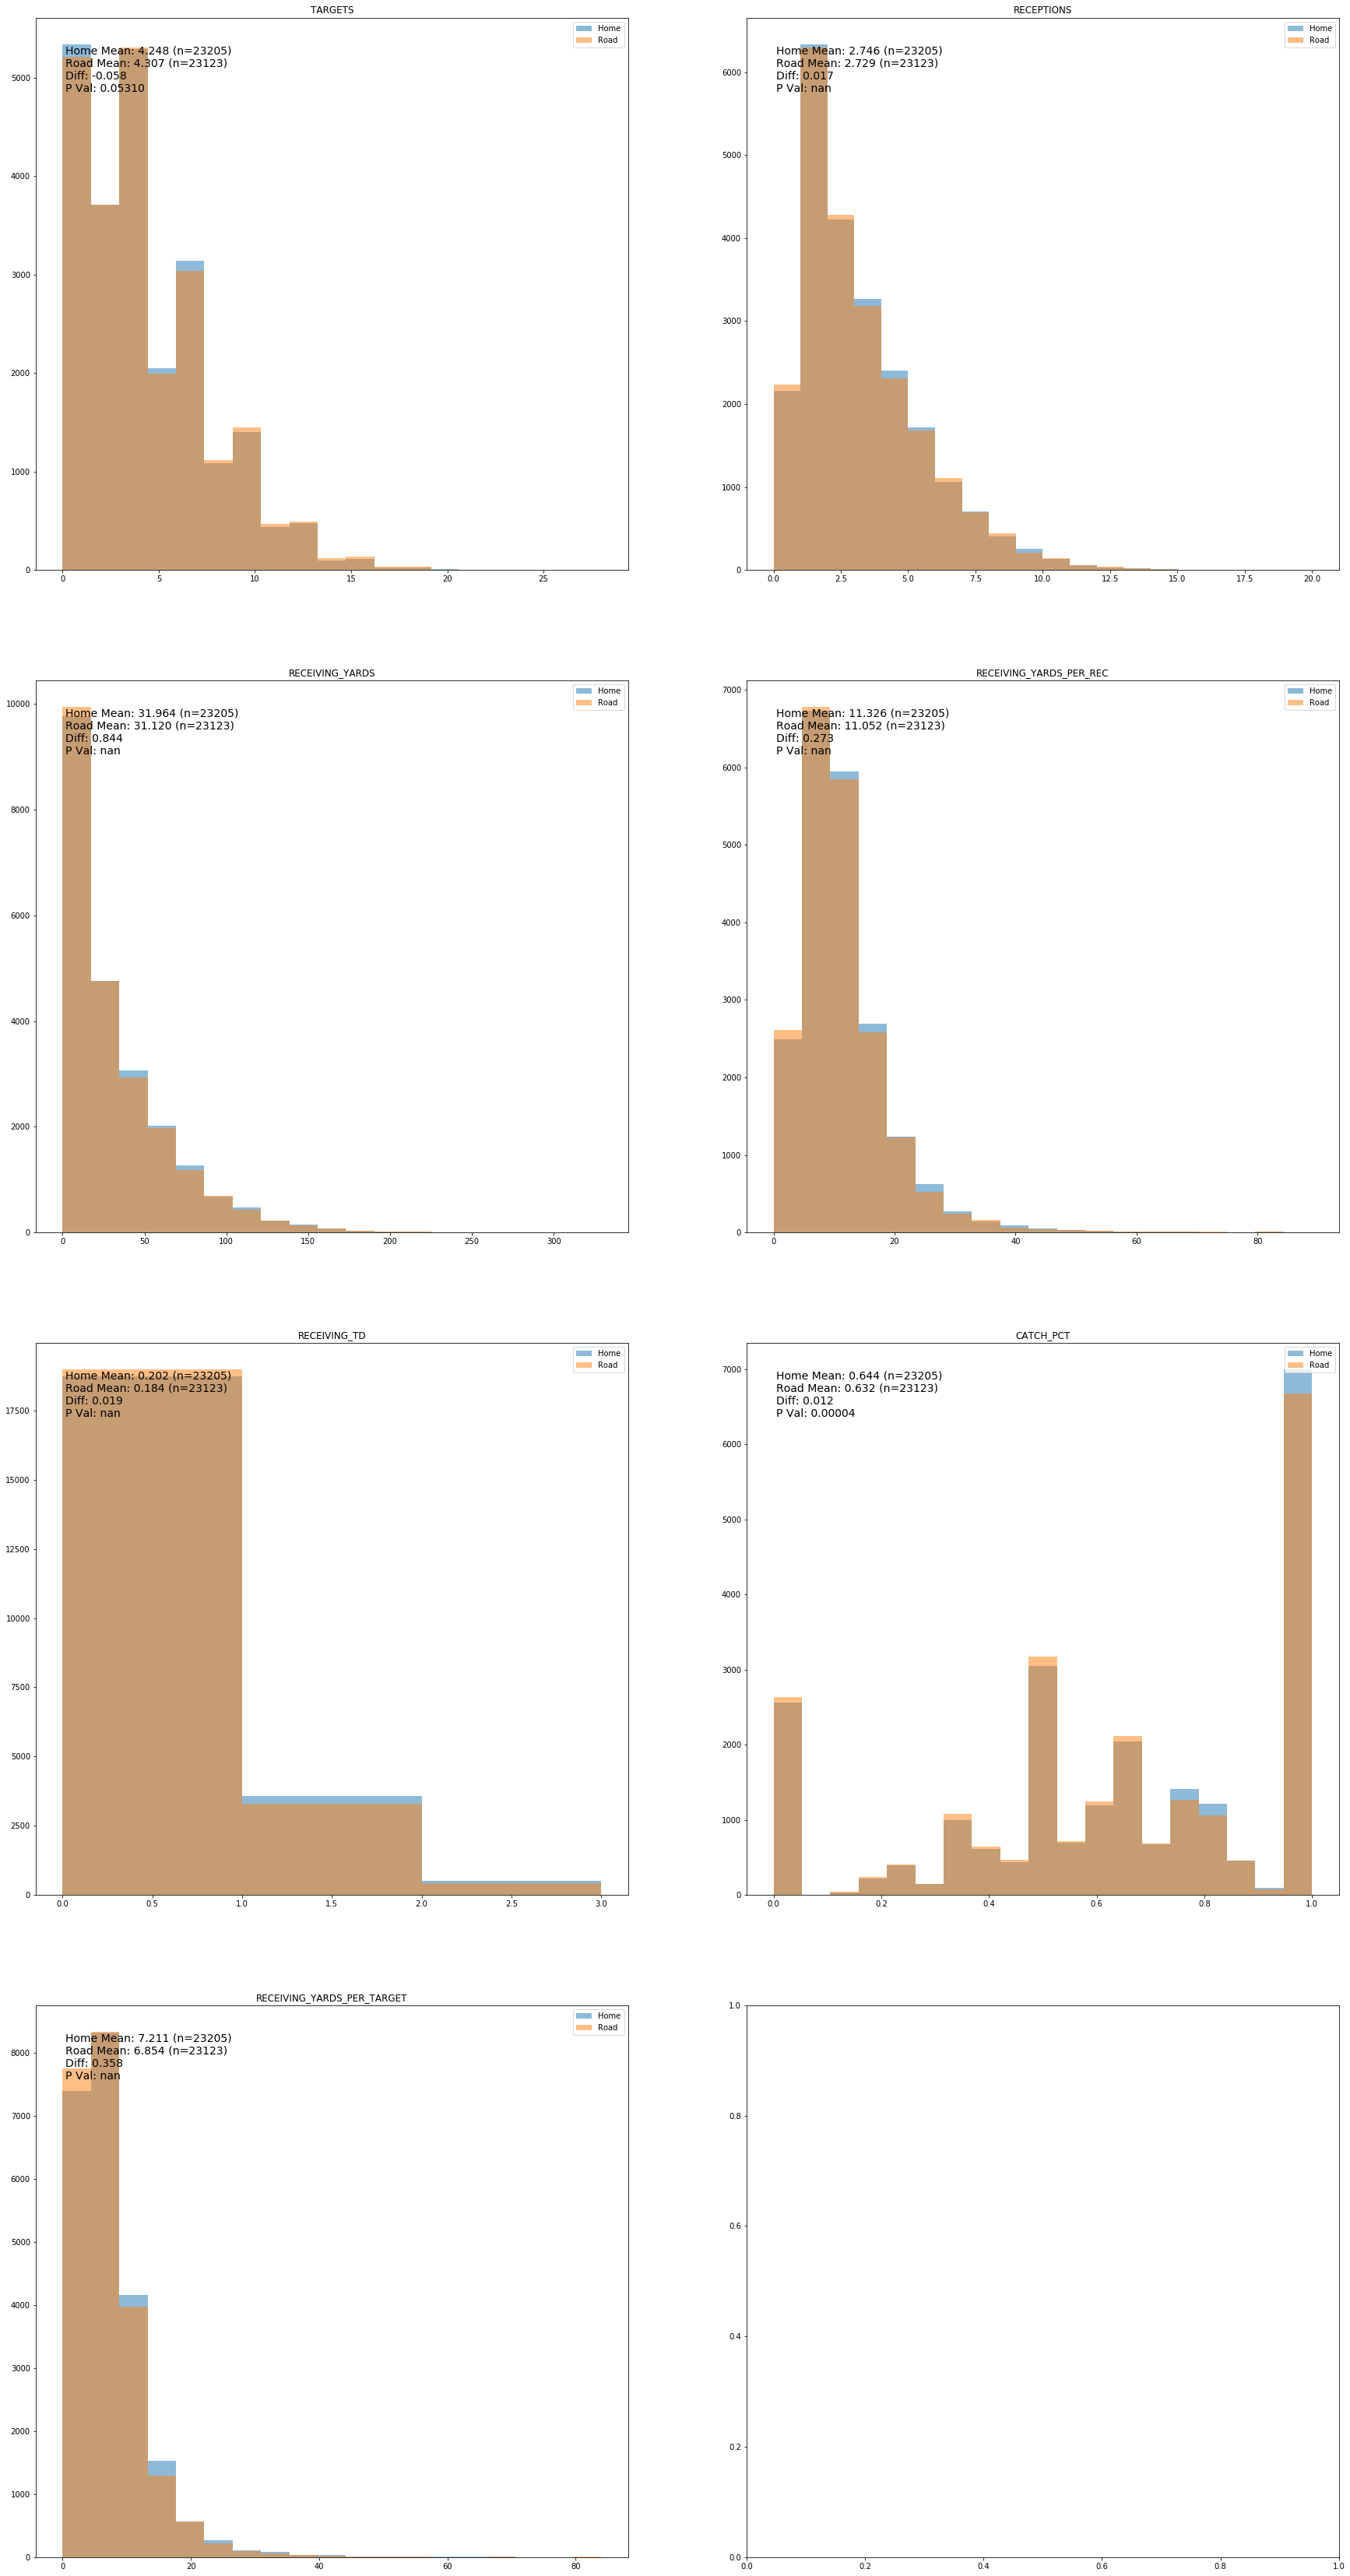

In [134]:
dt = 'receiving'
kvd = get_key_value_dict(dt)
hg = get_home_games(kvd.copy(), dt)
rg = get_road_games(kvd.copy(), dt)
stat_dict = get_stat_dict(hg, rg, get_stat_ids(dt))
plot_stats(hg, rg, dt)

In [136]:
write_all_aggregated_stats()

../../data/interim/passing/passing_YEAR_greaterEq_2008_PASS_ATTEMPTS_greaterEq_10.csv
../../data/interim/rushing/rushing_YEAR_greaterEq_2008_RUSH_ATTEMPTS_greaterEq_5.csv
../../data/interim/receiving/receiving_YEAR_greaterEq_2008.csv
